# Finite Markov Chains


## Topics

- Definitions
- Simulation
- Marginal Distributions
- Irreducibility and Aperiodicity
- Stationary Distributions



## Overview

Markov chains are one of the most useful classes of stochastic processes.

They are flexible and supported by many elegant theoretical results, as well as being central to quantitative modeling.

In this lecture, we 

* review some of the theory of Markov chains.
* implement key ideas in Python
* introduce some of the routines for working with Markov chains available in [QuantEcon.py](https://quantecon.org/quantecon-py/).

In [1]:
#!pip install quantecon  # Uncomment if needed

Let’s start with some imports:

In [2]:
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import numba

## Definitions

We recall some elementary definitions.


### Stochastic Matrices


A **stochastic matrix** (or **Markov matrix**)  is an $ n \times n $ square matrix $ P $
such that

1. each element is nonnegative and  
1. each row sums to one.


Each row of $ P $ can be regarded as a probability mass function over $ n $ possible outcomes.

It is simple to check that if $ P $ is a stochastic matrix, then so is the $ k $-th power $ P^k $ for all $ k \in \mathbb N $.


### Markov Chains

Let $ S $ be a finite set with $ n $ elements $ \{x_1, \ldots, x_n\} $.

We call $ S $ the **state space**.

A **Markov chain** $ \{X_t\} $ on $ S $ is a sequence of random variables on $ S $ that have the **Markov property**.

This means that, for any date $ t $ and any state $ y \in S $,


$$
    \mathbb P \{ X_{t+1} = y  \,|\, X_t \}
    = \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots X_0\} 
$$

In other words, knowing the current state is enough to know probabilities for future states.

In particular, the dynamics of a Markov chain are fully determined by the set of values

$$
    P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
    \qquad (x, y \in S) 
$$

We can view $ P $ as a stochastic matrix where

$$
P_{ij} = P(x_i, x_j)
\qquad 1 \leq i, j \leq n
$$

Going the other way, if we take a stochastic matrix $ P $, we can generate a Markov
chain $ \{X_t\} $ as follows:

- draw $ X_0 $ from a marginal distribution $ \psi $  
- for each $ t = 0, 1, \ldots $, draw $ X_{t+1} $ from $ P(X_t,\cdot) $

### Example 1

Consider a worker who, at any given time $ t $, is either unemployed (state 0) or employed (state 1).

Suppose that, over a one month period,

1. An unemployed worker finds a job with probability $ \alpha \in (0, 1) $.  
1. An employed worker loses her job and becomes unemployed with probability $ \beta \in (0, 1) $.  


In terms of a Markov model, we have

- $ S = \{ 0, 1\} $  
- $ P(0, 1) = \alpha $ and $ P(1, 0) = \beta $  


We can write out the transition probabilities in matrix form as

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta      & 1 - \beta
\end{array}
  \right) 
$$

Once we have the values $ \alpha $ and $ \beta $, we can address a range of questions, such as

- What is the average duration of unemployment?  
- Over the long-run, what fraction of time does a worker find herself unemployed?  

We'll see how to do this below.

### Example 2

From  US unemployment data, James Hamilton estimated the stochastic matrix

$$
P =
\left(
  \begin{array}{ccc}
     0.971 & 0.029 & 0 \\
     0.145 & 0.778 & 0.077 \\
     0 & 0.508 & 0.492
  \end{array}
\right)
$$

where

* the frequency is monthly  
* the first state represents “normal growth”  
* the second state represents “mild recession”  
* the third state represents “severe recession”  

For example, the matrix tells us that when the state is normal growth, the state will again be normal growth next month with probability 0.97.

In general, large values on the main diagonal indicate persistence in $ \{ X_t \} $.

This Markov process can also be represented as a directed graph, with edges labeled by transition probabilities

![https://python.quantecon.org/_static/lecture_specific/finite_markov/hamilton_graph.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/hamilton_graph.png)

  

## Simulation

One natural way to study Markov chains is to simulate them.

(The LLN tells us that to approximate the probability of event $ E $, we can simulate many times and count the fraction of times that $ E $ occurs).

Let's start by writing our own routines for generating sample paths (Markov chains).

(Later we'll use routines in [QuantEcon.py](http://quantecon.org/quantecon-py).)

In these exercises, we’ll take the state space to be $ S = 0,\ldots, n-1 $.

### Rolling Our Own

To simulate a Markov chain, we need its stochastic matrix $ P $ and a marginal probability distribution $ \psi $  from which to  draw a realization of $ X_0 $.

The Markov chain is then constructed as discussed above.  To repeat:

1. At time $ t=0 $, draw a realization of  $ X_0 $  from $ \psi $.  
1. At each subsequent time $ t $, draw a realization of the new state $ X_{t+1} $ from $ P(X_t, \cdot) $.  


To implement this simulation procedure, we need a method for generating draws from a discrete distribution.

For this task, we’ll use `random.draw` from [QuantEcon](http://quantecon.org/quantecon-py), which is accelerated by Numba and works as follows:

In [3]:
ψ = (0.3, 0.7)           # Probabilities over {0, 1}
cdf = np.cumsum(ψ)       # Convert into cummulative distribution
qe.random.draw(cdf, 5)   # Generate 5 independent draws from ψ

array([0, 1, 1, 1, 1])

We’ll write our code as a function that accepts the following three arguments

- A stochastic matrix `P`  
- An initial state `init`  
- A positive integer `sample_size` representing the length of the time series the function should return

In [4]:
def mc_sample_path(P, ψ_0=None, sample_size=1_000):
    """
    Generate a sample path of a finite state Markov chain with transition matrix
    P and initial distribution ψ_0.


    If ψ_0 is set to None then the initial draw will be uniform over the states.

    """

    # Set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)

    # draw initial state, defaulting to 0
    if ψ_0 is None:
        X_0 = 0
    else:
        ψ_0 = np.cumsum(ψ_0)
        X_0 = qe.random.draw(ψ_0)

    # Convert each row of P into a cdf
    P = np.cumsum(P, axis=1)

    # Simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P[X[t], :])

    return X

Let’s see how it works using the small matrix

In [5]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

As we’ll see later, for a long series drawn from `P`, the fraction of the sample that takes value 0 should be about 0.25.

The following code illustrates this

In [6]:
%%time

X = mc_sample_path(P, ψ_0=(0.1, 0.9), sample_size=1_000_000)
np.mean(X == 0)  # Fraction of time that X_t = 0

CPU times: user 924 ms, sys: 0 ns, total: 924 ms
Wall time: 924 ms


0.249566

Here we chose a particular initial condition but the result holds regardless of the initial distribution.

You can try changing the initial distribution to confirm this.


### Using QuantEcon’s Routines

[QuantEcon.py](http://quantecon.org/quantecon-py) has routines for handling Markov chains, including simulation.

Here’s an illustration using the same P as the preceding example

In [7]:
from quantecon import MarkovChain

mc = qe.MarkovChain(P)
X = mc.simulate(ts_length=1_000_000)
np.mean(X == 0)

0.250702

The [QuantEcon.py](http://quantecon.org/quantecon-py) routine is [JIT compiled](https://python-programming.quantecon.org/numba.html#numba-link) and hence faster.

In [8]:
%time mc_sample_path(P, sample_size=1_000_000) # Our homemade version

CPU times: user 898 ms, sys: 0 ns, total: 898 ms
Wall time: 897 ms


array([0, 1, 0, ..., 1, 1, 1])

In [9]:
%time mc.simulate(ts_length=1_000_000)         # QE version

CPU times: user 13.5 ms, sys: 0 ns, total: 13.5 ms
Wall time: 12.5 ms


array([1, 0, 1, ..., 0, 1, 1])

**Exercise**

Try producing your own JIT compiled version of our homemade function `mc_sample_path`, using Numba.

Hints:

- You might need to replace `dtype=int` with `dtype=numba.int32` or similar
- To simplify logic, you can replace `ψ_0=None` with `ψ_0` and assume the initial distribution is always passed in.

How does the timing compare to the original and the QuantEcon routine?

In [10]:
for i in range(12):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


**Solution**

Here's one solution.

In [11]:
@numba.jit
def mc_sample_path_fast(P, ψ_0,  sample_size=1_000):

    # Set up
    P = np.asarray(P)
    ψ_0 = np.asarray(ψ_0)
    X = np.empty(sample_size, dtype=numba.int64)

    # draw initial state
    ψ_0 = np.cumsum(ψ_0)
    X_0 = qe.random.draw(ψ_0)

    # Convert each row of P into a cdf
    P_cdf = np.empty_like(P)
    for i in range(len(P)):
        P_cdf[i, :] = np.cumsum(P[i, :])
    P = P_cdf
    
    # Simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P[X[t], :])
    return X

ψ_0 = (1, 0)
P = [[0.4, 0.6],
     [0.2, 0.8]]
P, ψ_0 = np.asarray(P), np.asarray(ψ_0)

In [12]:
%time mc_sample_path_fast(P, ψ_0, sample_size=1_000_000)

CPU times: user 479 ms, sys: 35.5 ms, total: 515 ms
Wall time: 516 ms


array([0, 0, 1, ..., 1, 1, 1])

In [13]:
%time mc_sample_path_fast(P, ψ_0, sample_size=1_000_000)

CPU times: user 25 ms, sys: 4.06 ms, total: 29.1 ms
Wall time: 29.1 ms


array([0, 1, 1, ..., 1, 1, 1])

Incidentally, we can also hold the stochastic matrix as state in a jitted function as follows.

In [14]:
def mc_sample_path_factory(P, ψ_0):

    # Set up
    P = np.asarray(P)
    ψ_0 = np.asarray(ψ_0)

    # draw initial state
    ψ_0 = np.cumsum(ψ_0)

    # Convert each row of P into a cdf
    P_cdf = np.empty_like(P)
    for i in range(len(P)):
        P_cdf[i, :] = np.cumsum(P[i, :])
    P = P_cdf

    @numba.jit
    def mc_sample_path_closure(sample_size=1_000):
        X_0 = qe.random.draw(ψ_0)
        X = np.empty(sample_size, dtype=numba.int32)
        # Simulate
        X[0] = X_0
        for t in range(sample_size - 1):
            X[t+1] = qe.random.draw(P[X[t], :])
        return X

    return mc_sample_path_closure

mc_sample_path_closure = mc_sample_path_factory(P, ψ_0)

In [15]:
%time mc_sample_path_closure(sample_size=1_000_000)

CPU times: user 267 ms, sys: 44.1 ms, total: 312 ms
Wall time: 313 ms


array([0, 1, 1, ..., 1, 0, 1], dtype=int32)

In [16]:
%time mc_sample_path_closure(sample_size=1_000_000)

CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 22.4 ms


array([0, 1, 1, ..., 0, 1, 1], dtype=int32)

## Marginal Distributions
Suppose that

1. $ \{X_t\} $ is a Markov chain with stochastic matrix $ P $  
1. the marginal distribution of $ X_t $ is known to be $ \psi_t $  


The law of total probability implies that

$$
\psi_{t+1}(y) = \sum_{x \in S} P(x,y) \psi_t(x)
\quad \text{for all } y \in S.
$$

If we think of $ \psi_{t+1} $ and $ \psi_t $ as *row vectors*, these $ n $ equations are summarized by the matrix expression


$$
\psi_{t+1} = \psi_t P 
$$

Thus, to move a marginal distribution forward one unit of time, we postmultiply by $ P $.

Repeating this $m$ times gives

$$
    X_0 \sim \psi_0 \quad \implies \quad X_m \sim \psi_0 P^m 
$$

### Example: Probability of Recession

Recall Hamilton's stochastic matrix $ P $ for recession and growth considered above

Suppose that the current state is unknown — perhaps statistics are available only  at the *end* of the current month.

We guess that the probability that the economy is in state $ x $ is $ \psi(x) $.

The probability of being in recession (either mild or severe) in 6 months time is given by the inner product

$$
\psi P^6
\cdot
\left(
  \begin{array}{c}
     0 \\
     1 \\
     1
  \end{array}
\right)
$$

Let's compute this when

In [17]:
ψ = (0.2, 0.4, 0.4)

To compute $P^6$ we use `np.power`.

In [18]:
P = ((0.971, 0.029, 0.0), 
     (0.145, 0.778, 0.077), 
     (0.0,   0.508, 0.492))

ψ @ np.power(P, 6) @ (0, 1, 1)

0.10125094566154497

### Irreducibility

Let $ P $ be a fixed stochastic matrix.

Two states $ x $ and $ y $ are said to **communicate** with each other if
there exist positive integers $ j $ and $ k $ such that

$$
    P^j(x, y) > 0
    \quad \text{and} \quad
    P^k(y, x) > 0
$$

This means that

- state $ x $ can eventually be reached  from state $ y $, and  
- state $ y $ can eventually  be reached from state $ x $  


The stochastic matrix $ P $ is called **irreducible** if all states
communicate; that is, if $ x $ and $ y $ communicate for all
$ (x, y) $ in $ S \times S $.

For example, consider the following transition probabilities for wealth of a fictitious set of
households

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility1.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility1.png)

  
We can translate this into a stochastic matrix, putting zeros where
there’s no edge between nodes

$$
P :=
\left(
  \begin{array}{ccc}
     0.9 & 0.1 & 0 \\
     0.4 & 0.4 & 0.2 \\
     0.1 & 0.1 & 0.8
  \end{array}
\right)
$$

It’s clear from the graph that this stochastic matrix is irreducible: we can  eventually
reach any state from any other state.

We can also test this using [QuantEcon.py](http://quantecon.org/quantecon-py)’s MarkovChain class

In [19]:
P_1 = [[0.9, 0.1, 0.0],
      [0.4, 0.4, 0.2],
      [0.1, 0.1, 0.8]]

mc = qe.MarkovChain(P_1, ('poor', 'middle', 'rich'))
mc.is_irreducible

True

Here’s a more pessimistic scenario in which  poor people remain poor forever

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility2.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_irreducibility2.png)

  
This stochastic matrix is not irreducible, since, for example, rich is not accessible from poor.

Let’s confirm this

In [20]:
P_2 = [[1.0, 0.0, 0.0],
      [0.1, 0.8, 0.1],
      [0.0, 0.2, 0.8]]

mc = qe.MarkovChain(P_2, ('poor', 'middle', 'rich'))
mc.is_irreducible

False

Irreducibility is important for understanding long run outcomes.

For example, poverty is a life sentence in the second graph but not the first.

**Exercise**

It's also true that an $n \times n$ stochastic matrix $P$ is irreducible if and only if $\sum_{i=0}^n P^i$ is everwhere positive.  

Write a function that checks irreducibility of given $P$ using this result and test it on $P_1$ and $P_2$ above.

In [21]:
for i in range(12):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


**Solution**

In [22]:
def is_irreducible(P):
    S = np.zeros_like(P)
    n = len(P)
    A = np.identity(n)
    for i in range(n+1):
        S += A
        A = A @ P
    return np.all(S > 0)

In [23]:
is_irreducible(P_1)

True

In [24]:
is_irreducible(P_2)

False

### Aperiodicity

Loosely speaking, a Markov chain is called **periodic** if it cycles in a predictable way, and **aperiodic** otherwise.

Here’s a trivial example with three states

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity1.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity1.png)

  
The chain cycles with period 3:

In [25]:
P = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0]]

mc = qe.MarkovChain(P)
mc.period

3

More formally, the **period** of a state $ x $ is the largest common divisor
of a set of integers

$$
    D(x) := \{j \geq 1 : P^j(x, x) > 0\}
$$

In the last example, $ D(x) = \{3, 6, 9, \ldots\} $ for every state $ x $, so the period is 3.

A stochastic matrix is called **aperiodic** if the period of every state is 1, and **periodic** otherwise.

For example, the stochastic matrix associated with the transition probabilities below is periodic because, for example, state $ a $ has period 2

![https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity2.png](https://python.quantecon.org/_static/lecture_specific/finite_markov/mc_aperiodicity2.png)

We can confirm that the stochastic matrix is periodic with the following code

In [26]:
P = [[0.0, 1.0, 0.0, 0.0],
     [0.5, 0.0, 0.5, 0.0],
     [0.0, 0.5, 0.0, 0.5],
     [0.0, 0.0, 1.0, 0.0]]

mc = qe.MarkovChain(P)

In [27]:
mc.is_aperiodic

False

## Stationary Distributions


We know that we can shift a marginal distribution forward one unit of time via postmultiplication by $ P $.

Some distributions are invariant under this updating process — for example,

In [28]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])
ψ = (0.25, 0.75)
ψ @ P

array([0.25, 0.75])

Such distributions are called **stationary** or **invariant**.


Formally, a marginal distribution $ \psi^* $ on $ S $ is called **stationary** for $ P $ if $ \psi^* = \psi^* P $.



**Theorem.** Every stochastic matrix $ P $ has at least one stationary distribution.

Proof:  This follows directly from the Perron-Frobenius theorem -- alternatively, see [EDTC](https://johnstachurski.net/edtc.html), theorem 4.3.5.

What's an example of a stochastic matrix with many stationary distributions?


**Theorem.** If $ P $ is both aperiodic and irreducible, then

1. $ P $ has exactly one stationary distribution $ \psi^* $.  
1. For any initial marginal distribution $ \psi_0 $, we have $ \| \psi_0 P^t - \psi^* \| \to 0 $ as $ t \to \infty $.  


For a proof, see, for example, theorem 5.2 of [[Haggstrom02](https://python.quantecon.org/zreferences.html#id135)].

(Note that part 1 of the theorem only requires  irreducibility, whereas part 2 requires both irreducibility and aperiodicity)

A stochastic matrix that satisfies the conditions of the theorem is sometimes called **uniformly ergodic**.

A sufficient condition for aperiodicity and irreducibility is that every element of $ P $ is strictly positive.

### Example

Recall our model of the employment/unemployment dynamics.

Assuming $ \alpha \in (0,1) $ and $ \beta \in (0,1) $, the uniform ergodicity condition is satisfied.

Let $ \psi^* = (p, 1-p) $ be the stationary distribution, so that $ p $ corresponds to unemployment (state 0).

Using $ \psi^* = \psi^* P $ and a bit of algebra yields

$$
    p = \frac{\beta}{\alpha + \beta}
$$

This is, in some sense, a steady state probability of unemployment — more about the  interpretation of this below.

Not surprisingly it tends to zero as $ \beta \to 0 $, and to one as $ \alpha \to 0 $.

### Calculating Stationary Distributions


As discussed above, a particular Markov matrix $ P $ can have many stationary distributions.

A fast algorithm for computing all stationary distributions is implemented in [QuantEcon.py](http://quantecon.org/quantecon-py).

In [29]:
P = [[0.4, 0.6],
     [0.2, 0.8]]

mc = qe.MarkovChain(P)
mc.stationary_distributions  # Show all stationary distributions

array([[0.25, 0.75]])

**Exercise**

Another option is to regard the system as an eigenvector problem: a vector
$ \psi $ such that $ \psi = \psi P $ is a left eigenvector associated
with the unit eigenvalue $ \lambda = 1$.

Try writing a function that uses this information to compute the stationary distribution of $P$.

Note that you can get the left eigenvectors by computing the ordinary (right) eigenvectors of the transpose of $P$.

Eigenvalues and eigenvectors can be obtained via `np.linalg.eig`.

In the exercise you can assume that $P$ has only one stationary distribution, and you can test your function using

In [30]:
P = np.array([[0.4, 0.6],
              [0.2, 0.8]])

In [31]:
for i in range(16):
    print("Solution below! 🦘")

Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘
Solution below! 🦘


**Solution**

In [32]:
def compute_stationary_via_eigenvecs(P):
    """
    Computes the stationary distribution of P using an eigenvector routine.

    We use the fact that, for a stochastic matrix, the largest left eigenvalue is 1.0.
    The corresponding eigenvector is the stationary distribution.
    """
    P = np.array(P)
    out = np.linalg.eig(P.T)
    eigvals, eigvecs = out.eigenvalues, out.eigenvectors
    i = np.argmax(eigvals)  # index of largest eigenvalue
    dominant_eigvec = eigvecs[:, i] 
    ψ_star = dominant_eigvec / np.sum(dominant_eigvec) # normalize
    return ψ_star

In [35]:
ψ_star

array([0.25, 0.75])

### Convergence to Stationarity


Part 2 of the Markov chain convergence theorem given above tells us that, under
the stated conditions, the marginal distribution of $ X_t $ converges to the
stationary distribution regardless of the initial condition.

This adds considerable authority to our interpretation of $ \psi^* $ as a stochastic steady state.

The convergence in the theorem is illustrated in the next figure

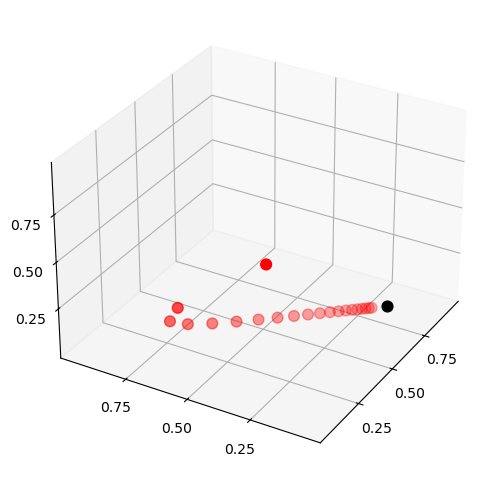

In [36]:
P = ((0.971, 0.029, 0.000),
     (0.145, 0.778, 0.077),
     (0.000, 0.508, 0.492))
P = np.array(P)

ψ = (0.0, 0.2, 0.8)        # Initial condition

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))

x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P

ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)

mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)

plt.show()

Here

- $ P $ is the stochastic matrix for recession and growth [considered above](#mc-eg2).  
- The highest red dot is an arbitrarily chosen initial marginal probability distribution  $ \psi $, represented as a vector in $ \mathbb R^3 $.  
- The other red dots are the marginal distributions $ \psi P^t $ for $ t = 1, 2, \ldots $.  
- The black dot is $ \psi^* $.  


You might like to try experimenting with different initial conditions.